In [ ]:
import numpy as np
import pandas as pd
import sklearn as skl
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy as dcopy

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score

In [ ]:
import torch
from torch.utils.data import Dataset , DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
# global var
phase = "train"

In [ ]:
def normalize(df):
    global phase, means, ranges
    df = np.array(df, "float64")
    if phase == "train":
        means = np.mean(df, axis=0)
        ranges = np.ptp(df, axis=0)
        zeros = np.where(ranges == 0)
        ranges[zeros] = 1
        means[zeros] = 0
        return (df - means) / ranges
    return (df - means) / ranges

In [ ]:
def one_hot(df, col_name, vals):
    if len(vals) == 2:
        val = vals[0]
        df[col_name +
            "_binary"] = df[col_name].apply(lambda x: 1 if x == val else 0)
        return df.drop(col_name, axis=1)
    for val in vals:
        df[col_name + "_" +
            val] = df[col_name].apply(lambda x: 1 if x == val else 0)
    return df.drop(col_name, axis=1)

In [ ]:
df = pd.read_csv("train.csv")
df_val = pd.read_csv("val.csv")

In [ ]:
df.head()

,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx,letter
0,4,7,5,5,4,7,6,7,5,6,4,7,3,7,3,7,N
1,3,9,4,7,2,7,6,14,5,8,13,7,3,9,0,8,U
2,3,3,4,4,1,7,7,4,4,7,6,8,3,8,4,8,X
3,4,5,5,4,5,8,8,4,4,7,7,8,5,10,9,10,S
4,6,9,8,7,5,4,9,6,7,7,10,11,3,9,1,8,U


In [ ]:
df.shape

(13000, 17)

In [ ]:
#only y onehot encoded
one_hot_dict={"letter": sorted(df["letter"].unique())}
print(one_hot_dict)

{'letter': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']}


In [ ]:
for col in df.columns:
  print(len(df[col].unique()))
#we might onehot encode all columns, tbd

16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
26


In [ ]:
def preprocess(df):
  col_and_type_dict = {
      #fill if we encod each columns
  }

  for col_name in col_and_type_dict.keys():
      df = one_hot(df, col_name, col_and_type_dict[col_name])
  return normalize(df)

In [ ]:
x_train = df.drop("letter" ,axis=1)
y_train = df[["letter"]]
x_val = df_val.drop("letter" ,axis=1)
y_val = df_val[["letter"]]

y_train = one_hot(y_train, "letter", one_hot_dict["letter"])
y_val = one_hot(y_val, "letter", one_hot_dict["letter"])

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
phase = "train"
x_train = preprocess(x_train)

phase="validation"
x_val = preprocess(x_val)

In [ ]:
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(13000, 16) (3500, 16) (13000, 26) (3500, 26)


In [ ]:
class trainData(Dataset):
    
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.x_data)


train_data = trainData(torch.FloatTensor(x_train), torch.LongTensor(y_train))


class testData(Dataset):
    
    def __init__(self, x_data,y_data):
        self.x_data = x_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]  

    def __len__ (self):
        return len(self.x_data)

val_data = testData(torch.FloatTensor(x_val),torch.LongTensor(y_val))

print("Length of training data is: {}".format(len(train_data)))
print("Length of test data is: {}".format(len(val_data)))

Length of training data is: 13000
Length of test data is: 3500


In [ ]:
BATCH_SIZE = 128

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE)

In [ ]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()        
        self.layer1 = nn.Linear(x_train.shape[1], 100)
        self.layer2 = nn.Linear(100, 50)
        self.layer3 = nn.Linear(50, y_train.shape[1])
        self.bn2 = nn.BatchNorm1d(50)

        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()

    def forward(self, input):
        x = self.relu1(self.layer1(input))
        x = F.dropout(x,0.3)
        x = self.relu2(self.layer2(x))
        # x = self.bn2(x)
        # sampled_noise = torch.autograd.Variable(torch.randn(x.shape).to(device) * 0.01)
        # x = x + sampled_noise
        x = F.dropout(x,0.2)
        x = self.layer3(x)
        return x
    
    def forward_test(self, input):
        x = self.relu1(self.layer1(input))
        # x = F.dropout(x,0.3)
        x = self.relu2(self.layer2(x))
        x = self.bn2(x)
        # sampled_noise = torch.autograd.Variable(torch.randn(x.shape).to(device) * 0.01)
        # x = x + sampled_noise
        # x = F.dropout(x,0.2)
        x = self.layer3(x)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MyNet()
model.to(device)
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
      layer.reset_parameters()

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [ ]:
EPOCHS = 1000
LEARNING_RATE = 0.003
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.5)
optimizer.zero_grad()
criterion = nn.CrossEntropyLoss()

In [ ]:
for e in range(EPOCHS):

    model.train()
    
    epoch_loss = 0
    correct = 0
    total = 0
    
    for x_train_batch, y_train_batch in train_loader:
        
        x_train_batch, y_train_batch = x_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()

        y_pred = model(x_train_batch)
        y_target = torch.argmax(y_train_batch, axis=1).reshape(-1)
        loss = criterion(y_pred, y_target)
        loss.backward()
        optimizer.step()

        predicted = torch.argmax(F.softmax(y_pred.data), axis=1)

        correct += (predicted == y_target).sum()
        total += float(len(y_train_batch))
        
        epoch_loss += loss.item()
    
    train_accuracies.append(correct*100/total)
    train_losses.append(epoch_loss/len(train_loader))

    model.eval()
    with torch.no_grad():
        val_loss = 0
        correct_val = 0
        total_val = 0
        for x_val_batch, y_val_batch in val_loader:
            
            x_val_batch, y_val_batch = x_val_batch.to(device), y_val_batch.to(device)

            y_predval = model(x_val_batch)
            y_target_val = torch.argmax(y_val_batch, axis=1).reshape(-1)
            loss = criterion(y_predval,y_target_val)
            
            predicted = torch.argmax(F.softmax(y_predval), axis=1)
            
            correct_val += (predicted==y_target_val).sum()
            total_val += float(len(y_val_batch))
            val_loss += loss.item()

    val_accuracies.append(float(correct_val*100/total_val))
    val_losses.append(val_loss/len(val_loader))
    if (e+1)%25==0:
        print(f'Train Accuracy | Epoch {e+1:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {correct*100/total:.3f}')
        print(f'Valid Accuracy | Epoch {e+1:03}: | Loss: {val_loss/len(val_loader):.5f} | Acc: {correct_val*100/total_val:.3f}\n')
        
    if val_losses[-1]==min(val_losses):
       best_model = dcopy(model)
    
    patience=100
    if e>patience:
        if val_losses[-1]>max(val_losses[-patience:-1]):
            break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train Accuracy | Epoch 025: | Loss: 0.40759 | Acc: 86.846
Valid Accuracy | Epoch 025: | Loss: 0.48734 | Acc: 84.743

Train Accuracy | Epoch 050: | Loss: 0.40566 | Acc: 86.554
Valid Accuracy | Epoch 050: | Loss: 0.48224 | Acc: 84.486

Train Accuracy | Epoch 075: | Loss: 0.40593 | Acc: 86.646
Valid Accuracy | Epoch 075: | Loss: 0.47067 | Acc: 85.286

Train Accuracy | Epoch 100: | Loss: 0.40296 | Acc: 86.438
Valid Accuracy | Epoch 100: | Loss: 0.46180 | Acc: 85.457

Train Accuracy | Epoch 125: | Loss: 0.40094 | Acc: 86.962
Valid Accuracy | Epoch 125: | Loss: 0.48734 | Acc: 84.429

Train Accuracy | Epoch 150: | Loss: 0.40319 | Acc: 86.538
Valid Accuracy | Epoch 150: | Loss: 0.47927 | Acc: 85.114

Train Accuracy | Epoch 175: | Loss: 0.40545 | Acc: 86.877
Valid Accuracy | Epoch 175: | Loss: 0.47188 | Acc: 85.143



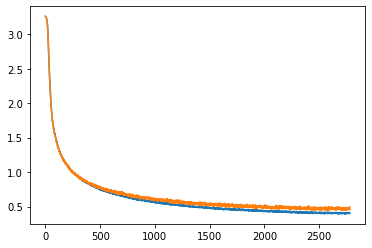

In [ ]:
plt.plot(train_losses)
plt.plot(val_losses)

In [ ]:
torch.save(model.state_dict(), "mymodel01.6")

In [ ]:
class MyNet01(nn.Module):
    def __init__(self):
        super(MyNet01, self).__init__()        
        self.layer1 = nn.Linear(x_train.shape[1], 100)
        self.layer2 = nn.Linear(100, 50)
        self.layer3 = nn.Linear(50, y_train.shape[1])
        self.bn2 = nn.BatchNorm1d(50)

        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()

    def forward(self, input):
        x = self.relu1(self.layer1(input))
        x = F.dropout(x,0.3)
        x = self.relu2(self.layer2(x))
        # x = self.bn2(x)
        # sampled_noise = torch.autograd.Variable(torch.randn(x.shape).to(device) * 0.01)
        # x = x + sampled_noise
        x = F.dropout(x,0.2)
        x = self.layer3(x)
        return x
    
    def forward_test(self, input):
        x = self.relu1(self.layer1(input))
        # x = F.dropout(x,0.3)
        x = self.relu2(self.layer2(x))
        x = self.bn2(x)
        # sampled_noise = torch.autograd.Variable(torch.randn(x.shape).to(device) * 0.01)
        # x = x + sampled_noise
        # x = F.dropout(x,0.2)
        x = self.layer3(x)
        return x

In [ ]:
best_model = MyNet01()
best_model.load_state_dict(torch.load("mymodel01.6"))
best_model.to(device)

MyNet01(
  (layer1): Linear(in_features=16, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=26, bias=True)
  (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (relu2): ReLU()
)

In [ ]:
best_model.eval()
with torch.no_grad():
  y_val_pred =best_model.forward_test(torch.FloatTensor(x_val).to(device))
  y_val_pred = torch.argmax(F.softmax(y_val_pred), axis=1).cpu()
  print("roc_auc", roc_auc_score(y_val_pred, y_val, multi_class="ovr"))
  print("f1", f1_score(y_val_pred, np.argmax(y_val, axis=1), average="macro"))
  print("acc", (np.array(y_val_pred)==np.argmax(y_val, axis=1)).mean())

for i in range(y_val.shape[1]):
  acc, total = 0, 0
  for j in range(y_val.shape[0]):
    if np.argmax(y_val[j]) == i:
      total+=1
      if y_val_pred[j] == i:
        acc+=1
  # print(chr(ord('A')+i), acc/total)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


0.9651831721822229
0.9305337462777759
0.9314285714285714


In [ ]:
df_test = pd.read_csv("test.csv")

phase="testing"
x_test = preprocess(df_test)

print(x_test.shape)
y_test = np.zeros(x_test.shape[0])
test_data = testData(torch.FloatTensor(x_test),torch.FloatTensor(y_val))

model.eval()
with torch.no_grad():
  y_test_pred = best_model.forward_test(torch.FloatTensor(x_test).to(device))
  y_test_pred = torch.argmax(F.softmax(y_test_pred), axis=1).cpu()

y_test_pred = np.array(y_test_pred).reshape(-1, 1)
id_col = np.array(list(range(0, len(y_test_pred)))).reshape(-1, 1)

np_test = np.concatenate((id_col, y_test_pred), axis=1)
df_test = pd.DataFrame(np_test, index=None, columns=["id", "letters"])
df_test["letters"] = df_test["letters"].apply(lambda x: chr(ord('A')+x))

(3500, 16)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


In [ ]:
df_test.head()

,id,letters
0,0,N
1,1,O
2,2,O
3,3,P
4,4,G


In [ ]:
df_test.to_csv("test_pred.csv", index=None)